Simulation finished at time: 10001.233295502527
Total completed jobs: 108206
Queue 0:
  Completed jobs: 29997
  Average wait time: 0.8560909959079228
  Average queue length: 2.1769621619126007
Queue 1:
  Completed jobs: 36728
  Average wait time: 0.9146520055892008
  Average queue length: 2.938762120636883
Queue 2:
  Completed jobs: 41481
  Average wait time: 0.9326438839655797
  Average queue length: 3.450324938671113
Server utilization: 0.8724474457744087

Final w vector:
[-1.16617977  0.1963726  -2.83777702  2.03222963 -1.16617977  0.08205167
 -2.83777702  2.03222963 -1.16617977  0.13883733 -2.83777702  2.03222963]

Last 5 updates of w:
time=9998.91, delta=-0.20817640662932568
[-1.16717643  0.19804412 -2.83967063  2.03312658 -1.16717643  0.08372319
 -2.83967063  2.03312658 -1.16717643  0.13606943 -2.83967063  2.03312658]
----------------------------------------
time=9999.19, delta=-0.20461742999445143
[-1.16807338  0.19714717 -2.83967063  2.03222963 -1.16807338  0.08282624
 -2.83967

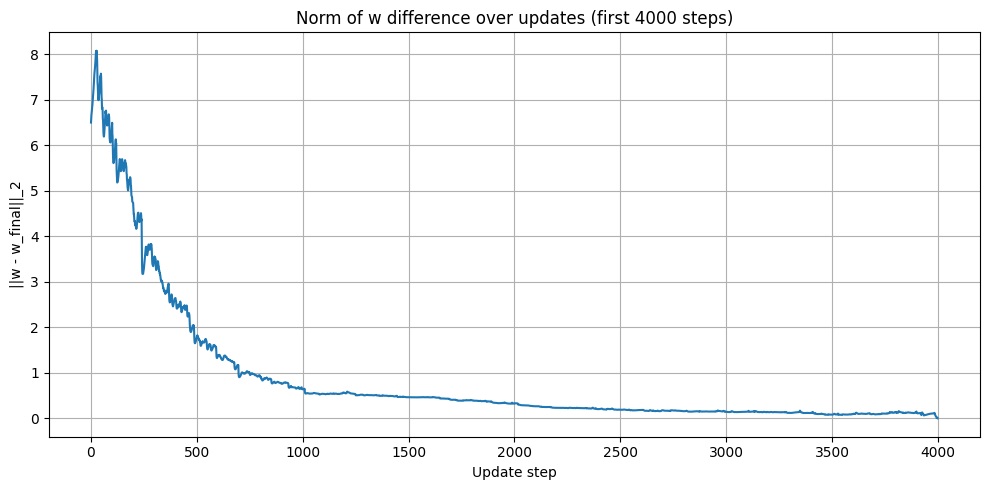

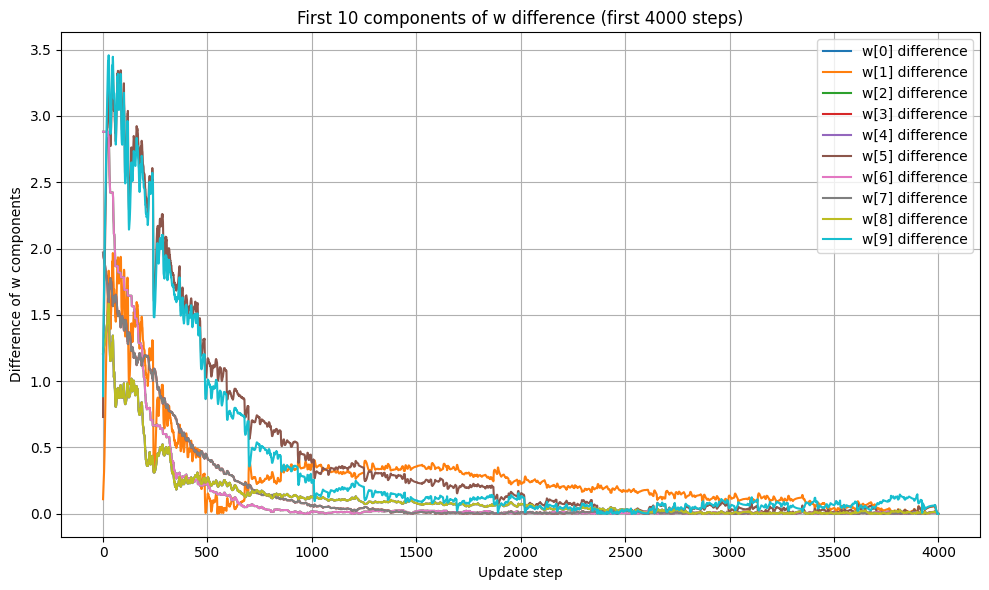

In [1]:
import numpy as np
import heapq
from collections import deque
import matplotlib.pyplot as plt

class Event:
    def __init__(self, event_type, time, queue_id=None, job_id=None):
        self.event_type = event_type
        self.time = time
        self.queue_id = queue_id
        self.job_id = job_id

    def __lt__(self, other):
        return self.time < other.time

class Queue:
    def __init__(self, arrival_rate, ini_jobs):
        self.queue = deque()
        self.arrival_rate = arrival_rate
        self.ini_jobs = ini_jobs
        self.total_jobs = 0
        self.completed_jobs = 0
        self.total_wait_time = 0
        self.last_queue_length = 0
        self.last_time = 0
        self.total_queue_length_time = 0

    def add_job(self, arrival_time):
        job_id = self.total_jobs
        self.queue.append((job_id, arrival_time))
        self.total_jobs += 1
        return job_id

    def process_job(self, current_time):
        if not self.queue:
            return None, 0, None
        job_id, arrival_time = self.queue.popleft()
        wait_time = current_time - arrival_time
        self.completed_jobs += 1
        self.total_wait_time += wait_time
        return job_id, wait_time, arrival_time

    def update_queue_stats(self, current_time):
        duration = current_time - self.last_time
        self.total_queue_length_time += self.last_queue_length * duration
        self.last_queue_length = len(self.queue)
        self.last_time = current_time

class Server:
    def __init__(self, service_rate, switch_time):
        self.service_rate = service_rate
        self.switch_time = switch_time
        self.state = 'idle'  # 'idle' / 'serving' / 'switching'
        self.current_queue = None
        self.current_job_id = None
        self.current_job_arrival_time = None
        self.last_state_change_time = 0.0
        self.total_busy_time = 0.0

    def update_utilization(self, current_time):
        duration = current_time - self.last_state_change_time
        if self.state in ['serving', 'switching']:
            self.total_busy_time += duration
        self.last_state_change_time = current_time

class PollingSystem:
    def __init__(self, queue_nums, arrival_rates, ini_jobs_list,
                 service_rate, switch_time, simulation_time):
        self.queue_nums = queue_nums
        self.queues = [Queue(arrival_rates[i], ini_jobs_list[i]) for i in range(queue_nums)]
        self.server = Server(service_rate, switch_time)
        self.event_queue = []
        self.current_time = 0.0
        self.simulation_time = simulation_time
        self.job_counter = 0

        # === AMQ / RL 参数 ===
        self.gamma = 0.9
        self.eta0 = 0.01
        self.step_counter = 0
        self.cost_attack = 8.0
        self.cost_defend = 6.0
        self.switch_cost_val = 1.0
        self.delta_clip = 50.0
        self.step_clip = 1e3

        # === [MODIFIED] 每个队列 4 维特征: [1, x_i + d_i, a, b] → w 维度 = 4n ===
        self.wk = np.zeros(4 * queue_nums)  # [MODIFIED]

        self.rl_history = []
        self.queue_length_records = []

        self.schedule_initial_events()

    def schedule_initial_events(self):
        initial_lengths = [len(q.queue) for q in self.queues]
        self.queue_length_records.append((self.current_time, initial_lengths))
        for qi, q in enumerate(self.queues):
            for _ in range(q.ini_jobs):
                q.add_job(self.current_time)
                self.job_counter += 1
        for i, queue in enumerate(self.queues):
            self.schedule_arrival(i)

    def record_queue_lengths(self):
        current_lengths = [len(q.queue) for q in self.queues]
        self.queue_length_records.append((self.current_time, current_lengths))

    def schedule_event(self, event):
        heapq.heappush(self.event_queue, event)

    def schedule_arrival(self, queue_id):
        rate = self.queues[queue_id].arrival_rate
        if rate <= 0:
            return
        inter_arrival = np.random.exponential(1.0 / rate)
        event_time = self.current_time + inter_arrival
        if event_time <= self.simulation_time:
            event = Event('arrival', event_time, queue_id)
            self.schedule_event(event)

    def schedule_service_completion(self, queue_id):
        service_time = np.random.exponential(1.0 / self.server.service_rate)
        event_time = self.current_time + service_time
        event = Event('service_completion', event_time, queue_id, self.server.current_job_id)
        self.schedule_event(event)

    def schedule_switch_completion(self, queue_id):
        event_time = self.current_time + self.server.switch_time
        event = Event('switch_completion', event_time, queue_id)
        self.schedule_event(event)

    def get_longest_queue(self):
        queue_lengths = [(len(queue.queue), i) for i, queue in enumerate(self.queues)]
        queue_lengths.sort(key=lambda x: (-x[0], x[1]))
        return queue_lengths[0][1] if queue_lengths and queue_lengths[0][0] > 0 else None

    def get_shortest_queue(self):
        queue_lengths = [(len(queue.queue), i) for i, queue in enumerate(self.queues)]
        queue_lengths.sort(key=lambda x: (x[0], x[1]))
        return queue_lengths[0][1] if queue_lengths and queue_lengths[0][0] >= 0 else None

    def compute_reward(self, X, a, b, ns=1.0):
        n = len(X)
        sx = float(sum(X))
        sxx = float(sum(x * x for x in X))
        if sxx > 0.0 and n > 0:
            fairness = (sx * sx) / (n * sxx)
        else:
            fairness = 0.0

        switch_cost = self.switch_cost_val * float(ns)
        cost_a = self.cost_attack * float(a)
        cost_b = self.cost_defend * float(b)

        return fairness - switch_cost - cost_a + cost_b

    # === [MODIFIED] 特征: 每个队列 4 维 [1, x_i + d_i, a, b]，不再包含平方项 ===
    def features(self, X, a, b):
        n = self.queue_nums
        xi = np.asarray(X, dtype=float)
        if n == 0:
            return np.zeros(0, dtype=float)

        max_val = np.max(xi)
        min_val = np.min(xi)
        idx_max = [i for i in range(n) if xi[i] == max_val]
        idx_min = [i for i in range(n) if xi[i] == min_val]

        feats = []
        for i in range(n):
            di = 0.0
            # (a,b)=(1,0) → 偏移加在最长队列；否则加在最短队列
            if (a == 1 and b == 0 and i in idx_max) or ((a, b) != (1, 0) and i in idx_min):
                di = 1.0
            val = xi[i] + di
            feats.extend([
                1.0,
                val,
                float(a),
                float(b),
            ])
        return np.array(feats, dtype=float)

    def q_value(self, w, X, a, b):
        return float(np.dot(w, self.features(X, a, b)))

    def update_wk(self, wk, phi_x, delta_k, eta):
        step = eta * phi_x * float(delta_k)
        if not np.all(np.isfinite(step)):
            return wk
        norm = float(np.linalg.norm(step))
        if norm > self.step_clip and norm > 0:
            step = step * (self.step_clip / norm)
        return wk + step

    def solve_theta_minimax(self, Q_next):
        best_c = float('inf')
        best_t = 0.0
        for t in np.linspace(0.0, 1.0, 201):
            th0, th1 = 1.0 - t, t
            f0 = th0 * Q_next[(0, 0)] + th1 * Q_next[(0, 1)]
            f1 = th0 * Q_next[(1, 0)] + th1 * Q_next[(1, 1)]
            c = max(f0, f1)
            if c < best_c:
                best_c, best_t = c, t
        return best_c, {0: 1.0 - best_t, 1: best_t}

    def run_simulation(self):
        while self.event_queue:
            event = heapq.heappop(self.event_queue)
            self.current_time = event.time
            if self.current_time > self.simulation_time:
                break

            if event.event_type == 'arrival':
                self.process_arrival(event.queue_id)
            elif event.event_type == 'service_completion':
                self.process_service_completion(event.queue_id, event.job_id)
                self.maybe_attack_defend()
            elif event.event_type == 'switch_completion':
                self.process_switch_completion(event.queue_id)

        for queue in self.queues:
            queue.update_queue_stats(self.simulation_time)
        self.server.update_utilization(self.simulation_time)

    # 行为策略 α,β: 按论文 (||x||_1 相关)
    def sample_actions_from_behavior(self, X):
        l1 = float(sum(X))
        # α(1|x) = exp(-||x||_1 / 2)
        p_attack = np.exp(-l1 / 2.0)
        a = 1 if np.random.rand() < p_attack else 0

        # β(1|x)
        if l1 != 0.0:
            p_defend = 1.0 - np.exp(-l1 / 2.0)
        else:
            p_defend = 0.5
        b = 1 if np.random.rand() < p_defend else 0
        return a, b

    def maybe_attack_defend(self):
        X_k = [len(q.queue) for q in self.queues]
        a, b = self.sample_actions_from_behavior(X_k)

        attack_success = (a == 1 and b == 0 and self.server.state == 'serving')

        R_k1 = self.compute_reward(X_k, a, b, ns=1.0)

        if attack_success:
            self.perform_attack()

        X_k1 = [len(q.queue) for q in self.queues]

        Q_next = {(aa, bb): self.q_value(self.wk, X_k1, aa, bb)
                  for aa in (0, 1) for bb in (0, 1)}
        c_star, theta = self.solve_theta_minimax(Q_next)

        q_curr = self.q_value(self.wk, X_k, a, b)
        delta_k = R_k1 + self.gamma * c_star - q_curr
        if not np.isfinite(delta_k):
            delta_k = 0.0
        else:
            delta_k = float(np.clip(delta_k, -self.delta_clip, self.delta_clip))

        phi = self.features(X_k, a, b)

        self.step_counter += 1
        K = 50000.0
        eta_k = self.eta0 / (1.0 + self.step_counter / K)

        self.wk = self.update_wk(self.wk, phi, delta_k, eta=eta_k)
        self.rl_history.append({
            "time": self.current_time,
            "X_k": X_k,
            "a": a,
            "b": b,
            "X_k1": X_k1,
            "R_k1": R_k1,
            "delta_k": float(delta_k),
            "c_star": float(c_star),
            "theta": theta,
            "w": self.wk.copy(),
        })

    def perform_attack(self):
        target_queue = self.get_shortest_queue()
        if target_queue is None or target_queue == self.server.current_queue:
            return
        if self.server.current_job_id is not None:
            self.queues[self.server.current_queue].queue.appendleft(
                (self.server.current_job_id, self.server.current_job_arrival_time)
            )
        self.server.update_utilization(self.current_time)
        self.server.state = 'switching'
        self.server.last_state_change_time = self.current_time
        self.server.current_job_id = None
        self.server.current_job_arrival_time = None
        self.schedule_switch_completion(target_queue)

    def process_arrival(self, queue_id):
        queue = self.queues[queue_id]
        queue.update_queue_stats(self.current_time)
        job_id = queue.add_job(self.current_time)
        self.job_counter += 1
        self.schedule_arrival(queue_id)
        if self.server.state == 'idle':
            self.start_next_service()

    def process_service_completion(self, queue_id, job_id):
        if self.server.current_job_id != job_id:
            return
        queue = self.queues[queue_id]
        queue.update_queue_stats(self.current_time)
        job_id, wait_time, arrival_time = queue.process_job(self.current_time)
        self.server.update_utilization(self.current_time)
        if job_id is not None:
            self.server.state = 'idle'
            self.server.current_job_id = None
            self.server.current_job_arrival_time = None
        self.start_next_service()

    def process_switch_completion(self, queue_id):
        self.server.update_utilization(self.current_time)
        self.server.state = 'idle'
        self.server.current_queue = queue_id
        self.start_next_service()

    def start_next_service(self):
        next_queue = self.get_longest_queue()
        if next_queue is None:
            self.server.state = 'idle'
            self.server.current_queue = None
            self.server.current_job_id = None
            self.server.current_job_arrival_time = None
            return
        queue = self.queues[next_queue]
        job_id, wait_time, arrival_time = queue.process_job(self.current_time)
        if job_id is None:
            self.server.state = 'idle'
            self.server.current_queue = None
            self.server.current_job_id = None
            self.server.current_job_arrival_time = None
            return
        self.server.update_utilization(self.current_time)
        self.server.state = 'serving'
        self.server.current_queue = next_queue
        self.server.current_job_id = job_id
        self.server.current_job_arrival_time = arrival_time
        self.schedule_service_completion(next_queue)

    def print_statistics(self):
        print("Simulation finished at time:", self.current_time)
        total_completed = sum(q.completed_jobs for q in self.queues)
        print("Total completed jobs:", total_completed)
        for i, queue in enumerate(self.queues):
            avg_wait = (queue.total_wait_time / queue.completed_jobs) if queue.completed_jobs > 0 else 0
            avg_queue_length = (queue.total_queue_length_time / self.current_time) if self.current_time > 0 else 0
            print(f"Queue {i}:")
            print("  Completed jobs:", queue.completed_jobs)
            print("  Average wait time:", avg_wait)
            print("  Average queue length:", avg_queue_length)
        util = (self.server.total_busy_time / self.current_time) if self.current_time > 0 else 0
        print("Server utilization:", util)

    def plot_w_evolution(self, max_dims=10, max_steps=4000):
        """
        绘制 w 的演化曲线，显示与收敛值的差的绝对值。
        只使用前 max_steps 次更新（如果实际更新步数不足，则使用全部）。
        """
        if not self.rl_history:
            print("No RL updates recorded.")
            return

        # 只取前 max_steps 个更新
        total_steps = len(self.rl_history)
        use_steps = min(max_steps, total_steps)

        # 0, 1, ..., use_steps-1
        steps = np.arange(use_steps)
        w_mat = np.array([self.rl_history[i]["w"] for i in range(use_steps)])  # (use_steps, d)

        # 计算与收敛值的差的绝对值
        final_w = w_mat[-1]  # 最后一个值
        diff_w_mat = np.abs(w_mat - final_w)  # 与最后值的差的绝对值

        # 图 1：||w||_2 的差值
        norms = np.linalg.norm(diff_w_mat, axis=1)
        plt.figure(figsize=(10, 5))
        plt.plot(steps, norms)
        plt.xlabel("Update step")
        plt.ylabel("||w - w_final||_2")
        plt.title(f"Norm of w difference over updates (first {use_steps} steps)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 图 2：前若干维分量的差值
        d = diff_w_mat.shape[1]
        dims = min(max_dims, d)
        plt.figure(figsize=(10, 6))
        for i in range(dims):
            plt.plot(steps, diff_w_mat[:, i], label=f"w[{i}] difference")
        plt.xlabel("Update step")
        plt.ylabel("Difference of w components")
        plt.title(f"First {dims} components of w difference (first {use_steps} steps)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



if __name__ == "__main__":
    queue_nums = 3
    arrival_rates = [3.0, 3.5, 4.0]
    ini_jobs_list = [0, 20, 18, 10]
    service_rate = 25.0
    switch_time = 2.0
    simulation_time = 10000.0

    new_system = PollingSystem(
        queue_nums=queue_nums,
        arrival_rates=arrival_rates,
        ini_jobs_list=ini_jobs_list,
        service_rate=service_rate,
        switch_time=switch_time,
        simulation_time=simulation_time,
    )

    new_system.run_simulation()
    optimal_wk = new_system.rl_history[-1]["w"]
    new_system.print_statistics()

    print("\nFinal w vector:")
    print(new_system.wk)

    if len(new_system.rl_history) > 0:
        print("\nLast 5 updates of w:")
        for rec in new_system.rl_history[-5:]:
            print(f"time={rec['time']:.2f}, delta={rec['delta_k']}")
            print(rec['w'])
            print("-" * 40)

    new_system.plot_w_evolution(max_dims=10)


Simulation finished at time: 10000.031602883566
Total completed jobs: 153156
Queue 0:
  Completed jobs: 49921
  Average wait time: 0.9352385727417515
  Average queue length: 4.282682985692456
Queue 1:
  Completed jobs: 51688
  Average wait time: 0.9884386445576325
  Average queue length: 4.695080134862208
Queue 2:
  Completed jobs: 51547
  Average wait time: 1.0328688170606166
  Average queue length: 4.914481232268676
Server utilization: 0.9430048500652267

Last 5 updates of rl_history:
time=9999.76, delta=0.004676474427792066
w: [-1.16617977  0.1963726  -2.83777702  2.03222963 -1.16617977  0.08205167
 -2.83777702  2.03222963 -1.16617977  0.13883733 -2.83777702  2.03222963]
----------------------------------------
time=9999.82, delta=-0.008565185872691394
w: [-1.16617977  0.1963726  -2.83777702  2.03222963 -1.16617977  0.08205167
 -2.83777702  2.03222963 -1.16617977  0.13883733 -2.83777702  2.03222963]
----------------------------------------
time=9999.83, delta=0.044534233292099046
w:

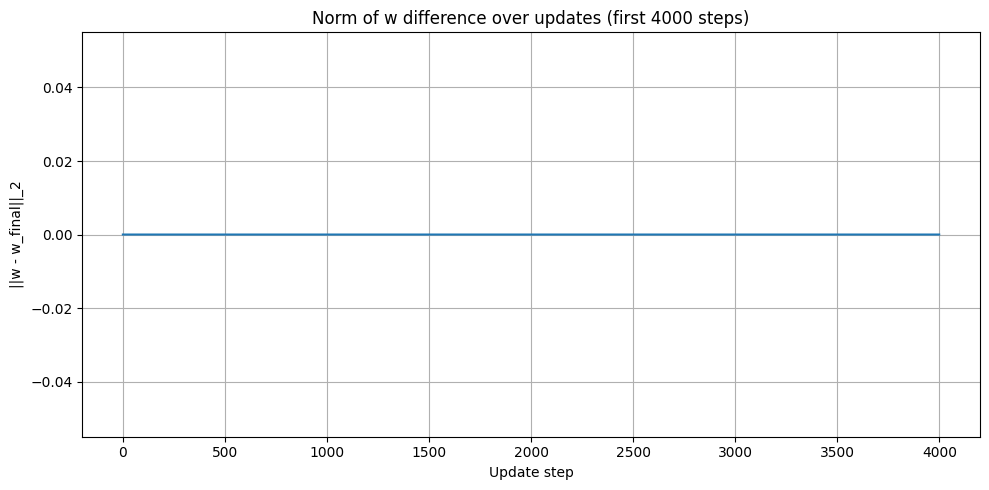

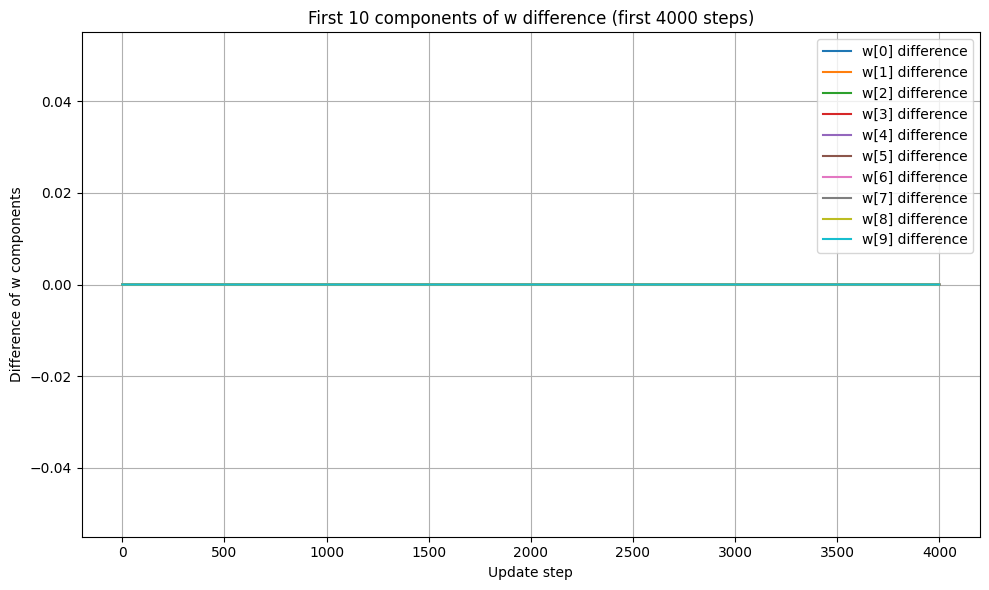

In [2]:
# 基于最优 w_k 来模拟实验，并记录 rl_history

class PollingSystemWithFixedPolicy(PollingSystem):
    def __init__(self, queue_nums, arrival_rates, ini_jobs_list,
                 service_rate, switch_time, simulation_time, optimal_wk):
        # 继承自原有的 PollingSystem 类
        super().__init__(queue_nums, arrival_rates, ini_jobs_list, service_rate, switch_time, simulation_time)
        
        # 使用外部提供的最优 w_k
        self.optimal_wk = optimal_wk
        self.rl_history = []  # 记录 RL 历史

    def run_simulation_with_fixed_policy(self):
        """
        运行模拟，但使用给定的最优 w_k 固定策略，不再进行 RL 更新。
        """
        while self.event_queue:
            event = heapq.heappop(self.event_queue)
            self.current_time = event.time
            if self.current_time > self.simulation_time:
                break

            if event.event_type == 'arrival':
                self.process_arrival(event.queue_id)
            elif event.event_type == 'service_completion':
                self.process_service_completion(event.queue_id, event.job_id)
                self.maybe_attack_defend_fixed_policy()
            elif event.event_type == 'switch_completion':
                self.process_switch_completion(event.queue_id)

        for queue in self.queues:
            queue.update_queue_stats(self.simulation_time)
        self.server.update_utilization(self.simulation_time)

    def maybe_attack_defend_fixed_policy(self):
        # 基于固定的最优 w_k 来选择动作
        X_k = [len(q.queue) for q in self.queues]
        a, b = self.sample_actions_from_fixed_policy(X_k)

        attack_success = (a == 1 and b == 0 and self.server.state == 'serving')

        # 计算奖励
        R_k1 = self.compute_reward(X_k, a, b, ns=1.0)

        if attack_success:
            self.perform_attack()

        X_k1 = [len(q.queue) for q in self.queues]

        Q_next = {(aa, bb): self.q_value(self.optimal_wk, X_k1, aa, bb)
                  for aa in (0, 1) for bb in (0, 1)}
        c_star, theta = self.solve_theta_minimax(Q_next)

        q_curr = self.q_value(self.optimal_wk, X_k, a, b)
        delta_k = R_k1 + self.gamma * c_star - q_curr
        if not np.isfinite(delta_k):
            delta_k = 0.0
        else:
            delta_k = float(np.clip(delta_k, -self.delta_clip, self.delta_clip))

        phi = self.features(X_k, a, b)

        # 记录强化学习历史
        self.rl_history.append({
            "time": self.current_time,
            "X_k": X_k,
            "a": a,
            "b": b,
            "X_k1": X_k1,
            "R_k1": R_k1,
            "delta_k": float(delta_k),
            "c_star": float(c_star),
            "theta": theta,
            "w": self.optimal_wk.copy(),
        })

    def sample_actions_from_fixed_policy(self, X):
        """
        基于给定的最优 w_k 固定策略来选择动作。
        """
        l1 = float(sum(X))
        # α(1|x) = exp(-||x||_1 / 2)
        p_attack = np.exp(-l1 / 2.0)
        a = 1 if np.random.rand() < p_attack else 0

        # β(1|x)
        if l1 != 0.0:
            p_defend = 1.0 - np.exp(-l1 / 2.0)
        else:
            p_defend = 0.5
        b = 1 if np.random.rand() < p_defend else 0
        return a, b

# 假设我们已经有了最优 w_k，可以从之前的实验中获得
if __name__ == "__main__":
    # 使用最优 w_k 来运行新的模拟实验
    system_fixed_policy = PollingSystemWithFixedPolicy(
        queue_nums=3,
        arrival_rates=[5.0, 5.0, 5.0],
        ini_jobs_list=[0, 20, 18],
        service_rate=25.0,
        switch_time=2.0,
        simulation_time=10000.0,
        optimal_wk=optimal_wk
    )

    # 运行模拟并记录历史
    system_fixed_policy.run_simulation_with_fixed_policy()
    system_fixed_policy.print_statistics()

    # 打印历史记录中的最后五次更新
    print("\nLast 5 updates of rl_history:")
    for rec in system_fixed_policy.rl_history[-5:]:
        print(f"time={rec['time']:.2f}, delta={rec['delta_k']}")
        print(f"w: {rec['w']}")
        print("-" * 40)

    # 绘制 w 的演化图
    system_fixed_policy.plot_w_evolution(max_dims=10)




> 在一个**轮询队列系统 + 攻击者 / 防御者博弈**的环境里，
> 用线性函数逼近一个零和博弈的 Q 函数 (Q_w(x,a,b))，
> 通过 TD + minimax 更新，让权重向量 (w) 收敛到一个「稳态」。

具体到代码：

* **状态 (X_k)**：

  ```python
  X_k = [len(q.queue) for q in self.queues]
  ```

  也就是每条队列当前的队长向量 ((x_1,\dots,x_n))。

* **动作空间**：

  * 攻击者：(a \in {0,1})，1 表示发起攻击
  * 防御者：(b \in {0,1})，1 表示防御
    所以 joint action 是 `(a,b)`，总共 4 种组合。

* **行为策略（固定，off-policy）**：
  在 `sample_actions_from_behavior(X)` 里写了：

  ```python
  l1 = sum(X)
  p_attack = exp(-l1 / 2)          # α(1|x)
  if l1 != 0:
      p_defend = 1 - exp(-l1 / 2)  # β(1|x)
  else:
      p_defend = 0.5
  ```

  * 队伍越长（系统越拥挤），攻击概率越小，防御概率越大；
  * 系统空的时候，两边差不多随缘。

* **环境动态**：

  * 平时是正常 polling：服务器总是服务当前最长队列；
  * 如果在某个决策点 `(a,b) = (1,0)` 且 server 正在服务，则攻击生效：
    抢占当前任务，插回队首，然后切换去服务最短队列。

* **Q 函数近似**：

  ```python
  Q_w(x,a,b) = w · φ(x,a,b)
  ```

  特征：对于每个队列 i：

  [
  \phi_i(x,a,b) = [1,\ x_i + d_i(x,a,b),\ a,\ b]
  ]

  所以总维度是 `4 * n`，`w` 也就是一个长度为 `4n` 的向量。

---

## 2. 每一步 RL 更新是怎么跑的？

整个 RL 更新全部塞在 `maybe_attack_defend` 里，在每一个 `service_completion` 事件之后触发一次。

### 步骤 1：读取当前状态

```python
X_k = [len(q.queue) for q in self.queues]
```

就是队长向量。

### 步骤 2：用行为策略采样 (a, b)

```python
a, b = self.sample_actions_from_behavior(X_k)
```

这里是固定的 α, β，**不是在学策略**，只是在这个行为策略下做值函数逼近（近似 minimax-Q）。

### 步骤 3：即时奖励 (R_{k+1})

```python
R_k1 = self.compute_reward(X_k, a, b, ns=1.0)
```

`compute_reward` 里：

```python
sx = sum(X)
sxx = sum(x * x for x in X)
fairness = (sx * sx) / (n * sxx)  # 如果 sxx>0
reward = fairness - switch_cost_val * ns - cost_attack * a + cost_defend * b
```

* `fairness`：
  [
  \frac{(\sum x_i)^2}{n \sum x_i^2}
  ]
  数值上处在 (0, 1] 之间，越「均衡」越接近 1，越偏斜越靠近 0。
* `switch_cost_val * ns`：切换成本，这里你直接设 `ns=1.0`，视为每个轮询周期付一次“轮转成本”。
* `cost_attack * a`：攻击者付出的成本，a=1 时扣 `8.0`。
* `cost_defend * b`：防御者 b=1 时加 `6.0`（从 Q 的定义看，是「被防守方」的立即收益）。

简单翻译就是：**公平性收益 − 切换代价 − 攻击代价 + 防御收益**。

### 步骤 4：对环境施加攻击副作用（如果攻击成功）

```python
attack_success = (a == 1 and b == 0 and self.server.state == 'serving')

if attack_success:
    self.perform_attack()
```

`perform_attack()` 做的事：

* 把当前正在服务的任务塞回当前队列队首；
* server 状态改为 `switching`；
* 目标队列改成 `最短队列`；
* 安排一个 `switch_completion` 事件。

这一步是对系统未来状态的真实影响。

### 步骤 5：得到下一状态 (X_{k+1})

```python
X_k1 = [len(q.queue) for q in self.queues]
```

因为攻击可能改了服务顺序 / 队长，这里拿的是“作用后”的状态。

### 步骤 6：计算未来的 minimax 价值 (c^*)

```python
Q_next = {(aa, bb): self.q_value(self.wk, X_k1, aa, bb)
          for aa in (0, 1) for bb in (0, 1)}
c_star, theta = self.solve_theta_minimax(Q_next)
```

`solve_theta_minimax` 做的是：

[
c^*(x_{k+1})
= \min_{\theta(\cdot|x)} \max_a \sum_b \theta(b|x) Q_w(x_{k+1}, a, b)
]

代码里用一维扫描：

* 用 t 表示 ( \theta(b=1|x) = t, \theta(b=0|x) = 1 - t)
* 对每个 t，算：

  ```python
  f0 = θ0 * Q(0,0) + θ1 * Q(0,1)
  f1 = θ0 * Q(1,0) + θ1 * Q(1,1)
  c = max(f0, f1)
  ```
* 在 t ∈ [0,1] 上找到 c 最小的位置，就是 (c^*)。

这就是 AMQ 里的零和博弈 Bellman 中的「内层 minimax」。

### 步骤 7：TD 残差 δ_k

```python
q_curr = self.q_value(self.wk, X_k, a, b)
delta_k = R_k1 + self.gamma * c_star - q_curr
delta_k = clip(delta_k, -100, 100)
```

形式就是：

[
\delta_k = r_{k+1} + \gamma c^*(X_{k+1}) - Q_w(X_k, a_k, b_k)
]

标准的一步 TD 残差，只不过 V 被换成了这个 minimax 的值 (c^*)。

### 步骤 8：特征 φ & 步长 η_k

```python
phi = self.features(X_k, a, b)

self.step_counter += 1
K = 50000.0
eta_k = self.eta0 / (1.0 + self.step_counter / K)
```

特征已经说过：

* 对每个队列 i：
  [
  [1,\ x_i + d_i(x,a,b),\ a,\ b]
  ]
* 总维度 `4n`。

步长：

[
\eta_k = \frac{\eta_0}{1 + k/K}
]

是标准 Robbins–Monro 型：

* 前期 η 大一点，更新快；
* 后期 η 慢慢变小，减少抖动，有利于收敛。

### 步骤 9：更新 w

```python
self.wk = self.update_wk(self.wk, phi, delta_k, eta=eta_k)
```

`update_wk` 里：

```python
step = eta * phi * delta_k
if norm(step) > step_clip:
    step *= step_clip / norm(step)
wk_new = wk + step
```

也就是：

[
w_{k+1} = w_k + \eta_k , \delta_k , \phi(X_k,a_k,b_k)
]

外加一个对步长向量的范数裁剪，防止偶发大残差把 w 直接轰到天上去。

然后记录一条：

```python
self.rl_history.append({
    ..., "w": self.wk.copy(),
})
```

方便后面画 `plot_w_evolution`。

---

## 3. 参数是怎么设的 & 它们在干什么？

你问的重点来了，这些参数不是乱写的，都是为了兼顾「能学到东西」和「不炸」这两件事。

### (1) 折扣因子 `gamma = 0.9`

```python
self.gamma = 0.9
```

* 有效视野大概是 (1 / (1 - \gamma) ≈ 10) 个决策步；
* 在这个轮询系统里，每次决策发生在服务完成之后，所以等价于看未来十次服务完成大概会如何；
* γ 太小：只看眼前奖励，学出来的东西偏 myopic；
  γ 太大：长期项主导，收敛会慢，对函数近似也更敏感。

0.9 是比较稳妥的折中。

---

### (2) 步长相关：`eta0 = 0.01, K = 50000`

```python
self.eta0 = 0.01
...
K = 50000.0
eta_k = self.eta0 / (1.0 + self.step_counter / K)
```

也就是：

[
\eta_k \approx
\begin{cases}
0.01 & k \ll 50000 \
\frac{0.01}{1 + k/50000} & k 大了以后慢慢变成几千分之一
\end{cases}
]

设成这样的考虑：

* 仿真时间 `simulation_time = 10000.0`，服务率 15、3 条队列，大致会有不少于数万次 service completion，也就是数万次 RL 更新；
* 前几万步希望步长够大，可以快速把 w 从 0 拉到合理区域；
* 几万步之后，步长减小，抖动变小，你画出来的 `w` 曲线会更像“收敛到某个带噪的小区间”，而不是乱飘。

如果你把 `eta0` 提到 0.1，或者把 K 缩小十倍，你会明显看到更新更剧烈，收敛容易炸。

---

### (3) 成本参数：`cost_attack, cost_defend, switch_cost_val`

```python
self.cost_attack = 8.0   # c_a
self.cost_defend = 6.0   # c_b
self.switch_cost_val = 1.0
```

回顾 reward 结构：

[
r = \text{fairness} - C_{\text{switch}} n_s - c_a a + c_b b
]

大概量级关系：

* `fairness ∈ (0,1]`，数量级 O(1)；
* switch cost = 1，跟 fairness 同一量级；
* attack cost = 8，defend benefit = 6，明显大过 fairness 的贡献。

这意味着：

* 频繁攻击是非常昂贵的，只有在“长期公平性收益 + 切换影响”能抵消这 8 的时候才值得；
* 防守则是“有点收益”，但也不会压倒一切。

设成这样是为了让 reward 在数值上不至于太小（全是 0.0x），也不至于太夸张（上百），方便 TD 稳定。

---

### (4) 裁剪参数：`delta_clip` 和 `step_clip`

```python
self.delta_clip = 100.0
self.step_clip = 1e3
```

* `delta_clip`：
  防止某个状态下 reward + γ c* 极端大或者 Q 值还没收敛时，残差爆炸：

  ```python
  delta_k = clip(delta_k, -100, 100)
  ```

* `step_clip`：
  即便 δ 在 [-100,100]，φ 里有 `x_i + d_i`，如果队长偶发变大，更新向量还是可能很长，所以对整步更新向量做范数裁剪：

  ```python
  if norm(step) > 1e3:
      step *= 1e3 / norm(step)
  ```

这俩本质上是**数值保险丝**，为了防止你跑多一点时间，w 全变成 `nan`。

---

### (5) 环境负载参数：`arrival_rates` 和 `service_rate`

```python
arrival_rates = [5.0, 5.0, 5.0]
service_rate = 15.0
```

综合三个队列，总到达率大约 15，服务率 15，看起来像是负载刚好 1。不过注意服务器是单台轮询，实际有效利用率没那么极限，加上攻击 / 切换的干扰，系统不会直接爆队伍到天上去，但也不算轻载。

这个水平有几个好处：

* 队长有变化，不是一直在 0–1 附近晃；
* 但又不至于无穷增长，让 RL 在“稳态附近”采样大量状态，满足 AMQ 收敛的 ergodicity 前提。

---

### (6) 仿真时长 `simulation_time = 10000.0`

```python
simulation_time = 10000.0
```

这不是“步数”，而是连续时间长度。
因为服务率 15、切换时间 0，大致会有数量级上万次 service completion，也就是上万次 RL 更新。

你之前发现 w 不太“好看”的一个重要原因，就是仿真时间太短，更新步数太少。AMQ 这种 SA 过程，本来就需要几万甚至几十万步才开始“看起来像收敛”。

---

## 总结

就这份文件里的 RL 来说，结构是：

* **状态**：队长向量 (X)
* **动作**：攻防 `(a,b)`
* **行为策略**：固定 α(x), β(x)，随 (|x|_1) 变化
* **价值函数**：线性近似 (Q_w(x,a,b) = w^T φ(x,a,b))
* **Bellman 目标**：零和博弈形式，右端有一个 `min_θ max_a E_θ Q` 的 (c^*)
* **更新**：TD + 递减步长 + 裁剪，典型随机逼近形式

参数整体是为了让：

* reward 与 Q 的数值在相对合理区间；
* 步长前期够大、后期慢慢收敛；
* 环境不会爆炸，Markov 链有稳态；
* 数值上不容易炸 nan。

